# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import sys
import matplotlib.pyplot as plt
import random
# import logging
from tqdm import tqdm
import scipy
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr


sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

 
from src.common.lib.utils import load_config_file, flat_list_of_lists
from src.datasets.dataset_spd import DatasetSPD
from cytoself.analysis.utils.pearson_correlation import selfcor_multi
from src.common.lib.data_loader import get_dataloader
from src.common.lib.model import Model




%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps
MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps


/home/labs/hornsteinlab/sagyk/anaconda3/envs/cytoself_torch/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labs/hornsteinlab/sagyk/anaconda3/envs/cytoself_torch/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labs/hornsteinla

Modules to reload:
all-except-skipped

Modules to skip:



# Configs

In [2]:
config_path_model = "./src/models/neuroself/configs/model_config/TLNeuroselfB78NoDSModelConfig"
config_path_data = "./src/datasets/configs/embeddings_data_config/EmbeddingsB9TestDatasetConfig"

# Utils

In [3]:
from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.special import softmax
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import jensenshannon
# Compute the probability distributions of codeword usage for each image
# image1_distribution = softmax(ind_g3bp1_hist_untreated1/20)
# image2_distribution = softmax(ind_g3bp1_hist_untreated/696)

# symmetrized version of KL divergence
# def jensen_shannon_divergence(P, Q):
#     M = 0.5 * (P + Q)
#     return 0.5 * (entropy(P, M) + entropy(Q, M))

def jensen_shannon_divergence(P, Q):
    return jensenshannon(P,Q) ** 2


def __calculate_cellid_ondim0_vqidx_ondim1_VQIND(
        model,
        ind=None,
        labels=None,
        vq_idx = 1,
        unique_labels = None,
        label_col = 0,
        # savepath = None,
    ):
        """
        Compute the matrix of cell line ID vs. vq index occurrence per image.
        This is needed to compute feature heatmap.

        Parameters
        ----------
        vq_idx : int
            VQ layer index
        data_loader : DataLoader
            DataLoader to compute the matrix
        unique_labels : Sequence or ArrayLike
            Unique labels
        label_col : int
            Label column index to use
        savepath : str
            Path to save the resulting matrix

        Returns
        -------
        Numpy array

        """
        if unique_labels is None:
            unique_labels = model.test_loader.dataset.unique_labels
        
        ##################################################
        ##################################################
        ##################################################
        # NOTE: 
        ####### NO! We need the real vec not the index for proper correlction testing!
        ####################################################
        ##################################################
        ##################################################
        
        
        output_layer = f'vqind{vq_idx}' #f'vqindhist{vq_idx}'  
        if ind is None:
            ind = model.trainer.infer_embeddings(model.test_loader, output_layer=output_layer)[0]
        print('Computing cell line ID vs vq index...')
        cellid_by_idx = np.zeros((len(unique_labels), ind.shape[-1]))
        if labels is None:
            labels = model.test_loader.dataset.label[:, label_col]
        for i, cid in enumerate(tqdm(unique_labels)):
            data0 = ind[labels == cid]
            cellid_by_idx[i, :] = data0.sum(0) / data0.shape[0]
        # if savepath:
        #     np.save(join(savepath, f'cellid_vqidx{vq_idx}.npy'), cellid_by_idx)
        return cellid_by_idx
    
def __calculate_cellid_ondim0_vqidx_ondim1_VQINDHIST(
        model,
        ind=None,
        labels=None,
        vq_idx = 1,
        unique_labels = None,
        label_col = 0,
        # savepath = None,
    ):
        """
        Compute the matrix of cell line ID vs. vq index occurrence per image.
        This is needed to compute feature heatmap.

        Parameters
        ----------
        vq_idx : int
            VQ layer index
        data_loader : DataLoader
            DataLoader to compute the matrix
        unique_labels : Sequence or ArrayLike
            Unique labels
        label_col : int
            Label column index to use
        savepath : str
            Path to save the resulting matrix

        Returns
        -------
        Numpy array

        """
        if unique_labels is None:
            unique_labels = model.test_loader.dataset.unique_labels
        
        ##################################################
        ##################################################
        ##################################################
        # NOTE: 
        ####### NO! We need the real vec not the index for proper correlction testing!
        ####################################################
        ##################################################
        ##################################################
        
        
        output_layer = f'vqindhist{vq_idx}'  
        if ind is None:
            ind = model.trainer.infer_embeddings(model.test_loader, output_layer=output_layer)[0]
        print(f'Computing cell line ID vs vq index... {len(unique_labels)}')
        cellid_by_idx = np.zeros((len(unique_labels), ind.shape[-1]))
        if labels is None:
            labels = model.test_loader.dataset.label[:, label_col]
        for i, cid in enumerate(tqdm(unique_labels)):
            data0 = ind[labels == cid]
            cellid_by_idx[i, :] = data0.sum(0) / data0.shape[0]
            print(data0, data0.shape, data0.sum(0), cellid_by_idx[i, :])
            raise Exception("STOP")
        # if savepath:
        #     np.save(join(savepath, f'cellid_vqidx{vq_idx}.npy'), cellid_by_idx)
        return cellid_by_idx
    
def __calculate_corr_vqind_vqindx(data, num_workers=1):
    print('Computing self Pearson correlation...')
    if data.shape[0] == 1:
        data = np.vstack([data, data])
    print(data.shape)
    corr_idx_idx = np.nan_to_num(selfcor_multi(data.T, num_workers=num_workers, method=pearsonr))
    
    return corr_idx_idx
    
# def calc_corr_vqind(vq_idx=1, use_codebook=False, model=None, ind=None, labels=None, unique_labels=None):
#     _mat_idx = __calculate_cellid_ondim0_vqidx_ondim1_VQIND(vq_idx=vq_idx, ind=ind, labels=labels, model=model, unique_labels=unique_labels ) \
#                 if not use_codebook \
#                 else model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()
#     corr_idx_idx = __calculate_corr_vqind_vqindx(_mat_idx, num_workers=2)
    
#     return corr_idx_idx

def calc_corr_vqindhist(vq_idx=1, use_codebook=False, model=None, ind=None, labels=None, unique_labels=None):
    _mat_idx = __calculate_cellid_ondim0_vqidx_ondim1_VQINDHIST(vq_idx=vq_idx, ind=ind, labels=labels, model=model, unique_labels=unique_labels) \
                if not use_codebook \
                else model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()
    corr_idx_idx = __calculate_corr_vqind_vqindx(_mat_idx, num_workers=2)
    
    return corr_idx_idx


def calculate_hamming_distance(arr1, arr2, percentage=True):
    hamming_perc = scipy.spatial.distance.hamming(arr1, arr2)
    
    if percentage:
        return hamming_perc
    
    return hamming_perc * len(arr1)

def calculate_pairwise_distance(data, distance_func, percentage=True):    
    dist = np.zeros((data.shape[0],)*2)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            dist[i,j] = distance_func(data[i], data[j], percentage=percentage)
    
    return dist


def select_samples_by_label(data, all_labels, labels_to_select, is_contains=False, n_samples=None, start_ind=None, end_ind=None):
    indxes = []
    
    for l in labels_to_select:
        mask = all_labels == l if not is_contains else np.char.find(all_labels, l) > -1
        indx = np.where(mask)[0]
        if n_samples is not None:
            indx = indx[:min(n_samples, len(indx))]
        if start_ind is not None:
            indx = indx[max(0, start_ind):]
        if end_ind is not None:
            indx = indx[:min(len(indx), end_ind)]
        indxes.append(indx)
        
    indxes = flat_list_of_lists(indxes)
    indxes = np.asarray(indxes)
    
    return data[indxes], all_labels[indxes]

def id2label(unique_markers, y_id):
    y_label = unique_markers[y_id.flatten().astype(int)]
    
    return y_label
    

# Main

In [4]:
# # Load configs
config_model = load_config_file(config_path_model, 'model')

2023-09-27 16:31:42 INFO [TLNeuroselfB78NoDSModelConfig] Init (log path: /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/logs/270923_163142_123386.log)
2023-09-27 16:31:42 INFO [TLNeuroselfB78NoDSModelConfig] MOMAPS_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps, MOMAPS_DATA_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps/input


In [5]:
# # Load configs
config_model = load_config_file(config_path_model, 'model')
config_data = load_config_file(config_path_data, 'data', config_model.CONFIGS_USED_FOLDER)
 
# Init dataset
dataset = DatasetSPD(config_data)
    
print(f"Data shape: {dataset.X_paths.shape}, {dataset.y.shape}")
 
# Setting up unique_markers
__unique_labels_path = os.path.join(config_model.MODEL_OUTPUT_FOLDER, "unique_labels.npy")
if os.path.exists(__unique_labels_path):
    print(f"unique_labels.npy files has been detected - using it. ({__unique_labels_path})")
    dataset.unique_markers = np.load(__unique_labels_path)
else:
    print(f"Couldn't find unique_labels file: {__unique_labels_path}")
    
dataset.flip, dataset.rot = False, False
if config_data.SPLIT_DATA:
    print("Split data...")
    _, _, indexes = dataset.split()
else:
    indexes = None

batch_size = config_model.BATCH_SIZE
num_workers = 1 # No need in more since eval takes only the first 10 tiles
print(f"Init dataloaders (batch_size: {batch_size}, num_workers: {num_workers})")
dataloader = get_dataloader(dataset, batch_size, indexes=indexes, num_workers=num_workers)    

print("Init model")
model = Model(config_model)

print("Loading model with dataloader")
model.load_with_dataloader(test_loader=dataloader)

print(f"Loading model (Path: {config_model.MODEL_PATH})")
model.load_model()



2023-09-21 14:55:17 INFO [TLNeuroselfB78NoDSModelConfig] Init (log path: /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/logs/210923_145517_588372.log)
2023-09-21 14:55:17 INFO [TLNeuroselfB78NoDSModelConfig] MOMAPS_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps, MOMAPS_DATA_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps/input
2023-09-21 14:55:17 INFO Input folder: /home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample, depth used: 3
2023-09-21 14:55:17 INFO Skipping marker (not in markers list). ANXA11
2023-09-21 14:55:17 INFO Skipping marker (not in markers list). CD41
2023-09-21 14:55:17 INFO Skipping marker (not in markers list). CLTC
2023-09-21 14:55:17 INFO Skipping marker (not in markers list). Calreticulin
2023-09-21 14:55:17 INFO Skipping marker (not in markers list). DCP1A
2023-09-21 14:55:17 INFO Filepath (npy): /home/labs/hornsteinlab/Collaboration/MOmaps/inp

Data shape: (2458,), (2458, 1)
unique_labels.npy files has been detected - using it. (/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/unique_labels.npy)
Init dataloaders (batch_size: 4, num_workers: 1)
Init model
Loading model with dataloader
Loading model (Path: /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/checkpoints/checkpoint_ep21.chkp)


/home/labs/hornsteinlab/sagyk/anaconda3/envs/cytoself_torch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(
2023-09-21 14:55:21 INFO Loading model from checkpoint /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/checkpoints/checkpoint_ep21.chkp


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [5]:
ind, labels = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/ind_b9_vqindhist1.npy"),\
                np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/labels_b9_1.npy")
# ind, labels = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/ind_b9_vqindhist2_partial.npy"),\
#                 np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/labels_b9_partial.npy")
 
__unique_labels_path = os.path.join(config_model.MODEL_OUTPUT_FOLDER, "unique_labels.npy")
if os.path.exists(__unique_labels_path):
    print(f"unique_labels.npy files has been detected - using it. ({__unique_labels_path})")
    unique_markers = np.load(__unique_labels_path)

ind = ind.reshape(ind.shape[0], -1)

print(ind.shape, labels.shape)
print(np.unique(labels).shape)

unique_labels.npy files has been detected - using it. (/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/unique_labels.npy)
(320151, 2048) (320151, 1)
(225,)


-------------

## VQ IND HIST

In [6]:
def get_labels_by_postfix(postfix):
    labels_unique = np.unique(labels)
    l = labels_unique[np.where(np.char.find(labels_unique, postfix) > -1)[0]]
    
    return l

def get_pdfs(postfix):
    l = get_labels_by_postfix(postfix) 
    X = []

    for ll in l:
        print(ll)
        x, y = select_samples_by_label(ind, labels, [ll], is_contains=True)#, end_ind=20)
        print(x.shape, len(y), np.unique(y))
        x_sum_norm = x.sum(0)/len(y)
        print(max(x_sum_norm), np.argmax(x_sum_norm))
        X.append(x_sum_norm)
        
    return X, l


In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import Isomap

# Define a distance function for Jensen-Shannon Divergence
# def jsd_pairwise_distances(X, Y=None, **kwargs):
#     return pairwise_distances(X, Y, metric=jensen_shannon_div, **kwargs)

# Extract at least one candidate from each unique label
unique_labels = np.unique(labels)#, return_index=True)
# vq_unique_subset = vq_histograms[indices, :]

# Apply Isomap with the JSD pairwise distance function on the unique subset
embedding_jsd_unique = Isomap(n_components=2, metric=jensen_shannon_divergence, n_jobs=-1)
isomap_2d_jsd_unique = embedding_jsd_unique.fit_transform(ind)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(isomap_2d_jsd_unique[:, 0], isomap_2d_jsd_unique[:, 1], alpha=0.6)
for idx, label in enumerate(unique_labels):
    plt.annotate(label, (isomap_2d_jsd_unique[idx, 0], isomap_2d_jsd_unique[idx, 1]), fontsize=6, alpha=0.7)
plt.title("Isomap with Jensen-Shannon Divergence (Unique Subset)")
plt.show()


In [77]:
np.unique(labels)

array(['ANXA11_FUSHeterozygous_Untreated',
       'ANXA11_FUSHomozygous_Untreated', 'ANXA11_FUSRevertant_Untreated',
       'ANXA11_OPTN_Untreated', 'ANXA11_SCNA_Untreated',
       'ANXA11_TBK1_Untreated', 'ANXA11_TDP43_Untreated',
       'ANXA11_WT_Untreated', 'ANXA11_WT_stress',
       'CD41_FUSHeterozygous_Untreated', 'CD41_FUSHomozygous_Untreated',
       'CD41_FUSRevertant_Untreated', 'CD41_OPTN_Untreated',
       'CD41_SCNA_Untreated', 'CD41_TBK1_Untreated',
       'CD41_TDP43_Untreated', 'CD41_WT_Untreated', 'CD41_WT_stress',
       'CLTC_FUSHeterozygous_Untreated', 'CLTC_FUSHomozygous_Untreated',
       'CLTC_FUSRevertant_Untreated', 'CLTC_OPTN_Untreated',
       'CLTC_SCNA_Untreated', 'CLTC_TBK1_Untreated',
       'CLTC_TDP43_Untreated', 'CLTC_WT_Untreated', 'CLTC_WT_stress',
       'Calreticulin_FUSHeterozygous_Untreated',
       'Calreticulin_FUSHomozygous_Untreated',
       'Calreticulin_FUSRevertant_Untreated',
       'Calreticulin_OPTN_Untreated', 'Calreticulin_SCNA_Untre

ANXA11_WT_Untreated
(1934, 2048) 1934 ['ANXA11_WT_Untreated']
13.649948 165
CD41_WT_Untreated
(1538, 2048) 1538 ['CD41_WT_Untreated']
9.172301 1312
CLTC_WT_Untreated
(1290, 2048) 1290 ['CLTC_WT_Untreated']
4.0666666 1971
Calreticulin_WT_Untreated
(1832, 2048) 1832 ['Calreticulin_WT_Untreated']
7.653384 396
DCP1A_WT_Untreated
(1598, 2048) 1598 ['DCP1A_WT_Untreated']
18.897997 500
FMRP_WT_Untreated
(1473, 2048) 1473 ['FMRP_WT_Untreated']
12.279022 152
FUS_WT_Untreated
(1449, 2048) 1449 ['FUS_WT_Untreated']
72.784676 37
G3BP1_WT_Untreated
(1475, 2048) 1475 ['G3BP1_WT_Untreated']
16.033897 330
GM130_WT_Untreated
(1358, 2048) 1358 ['GM130_WT_Untreated']
65.23196 1799
KIF5A_WT_Untreated
(1475, 2048) 1475 ['KIF5A_WT_Untreated']
7.1518645 314
LAMP1_WT_Untreated
(1832, 2048) 1832 ['LAMP1_WT_Untreated']
18.187227 1386
NCL_WT_Untreated
(1449, 2048) 1449 ['NCL_WT_Untreated']
33.94755 1033
NEMO_WT_Untreated
(1598, 2048) 1598 ['NEMO_WT_Untreated']
12.198373 1924
NONO_WT_Untreated
(1538, 2048) 1538 [

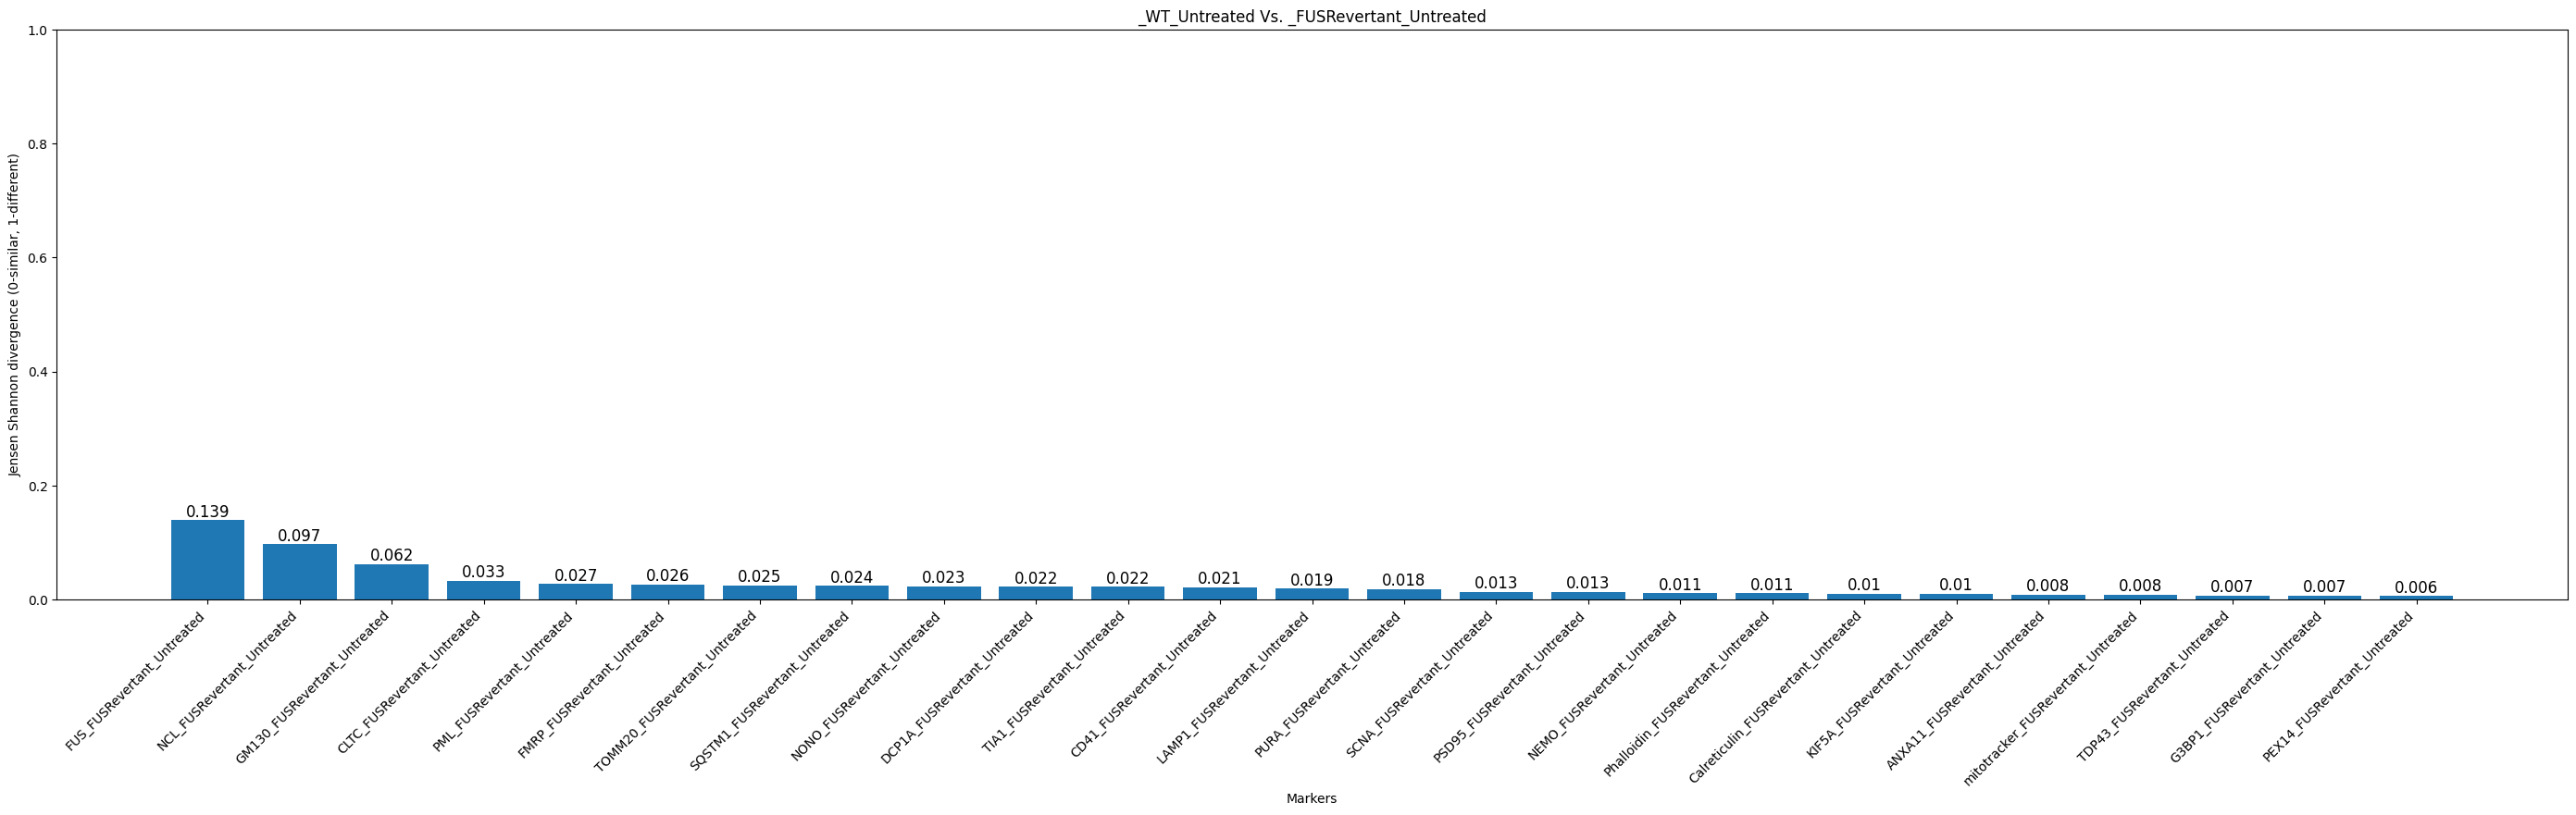

In [78]:
l0 = "_WT_Untreated"
l1 = "_FUSRevertant_Untreated"
X0, y0 = get_pdfs(l0)
X1, y1 = get_pdfs(l1)

# plt.plot(np.arange(0,2048), h0_x)
# # for x in X:
# #     plt.plot(np.arange(0,2048), x)#_distribution)
# plt.legend([h0_label] + l)
# plt.show()

distances = []

for i in range(len(X0)):
    # for j in range(i+1, len(X)):
    im0_i, im1_i = X0[i], X1[i]
    distances.append(round(jensen_shannon_divergence(im0_i, im1_i), 3))

distances = np.asarray(distances)
sorted_indexes = np.argsort(-distances)

distances_sorted = distances[sorted_indexes]
y1_sorted = y1[sorted_indexes]

plt.figure(figsize=(35,8))
plt.bar(y1_sorted, distances_sorted)

# Annotate the bars with their y-values
for i, v in enumerate(distances_sorted):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
    
plt.ylim(0,1)
plt.xlabel("Markers")
plt.ylabel("Jensen Shannon divergence (0-similar, 1-different)")
plt.xticks(rotation=45, ha='right')
plt.title(f"{l0} Vs. {l1}")
plt.show()


In [27]:
euclid_dist_sorted['WT_stress'].values

array([0.08743288, 0.12189687, 0.13436925, 0.14322274, 0.153126  ,
       0.15581225, 0.17665914, 0.17981223, 0.18813456, 0.19151199,
       0.20652338, 0.22489439, 0.23131479, 0.23824036, 0.2541027 ,
       0.27539139, 0.31613896, 0.32582707, 0.3427293 , 0.37479142,
       0.38803155, 0.39683666, 0.41145991, 0.41374469, 0.42696491])

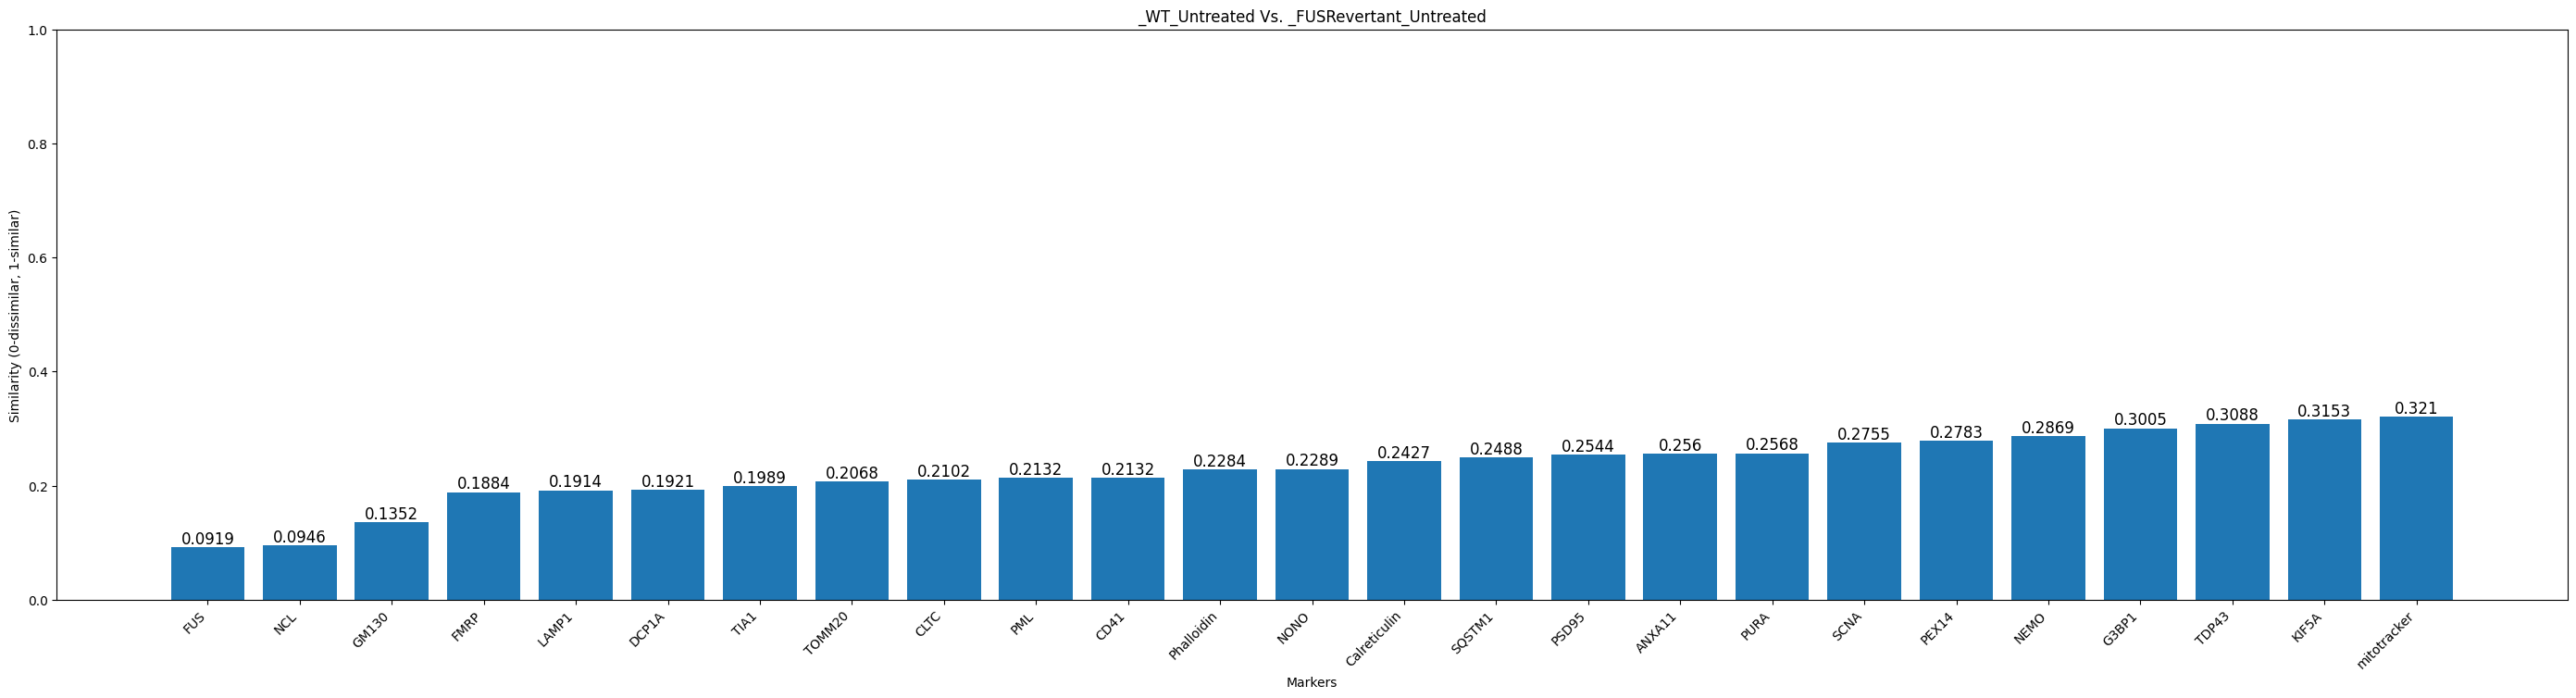

In [81]:
euclid_dist = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/distances/neurons/vqvec1/between_cell_lines_conds_similarities_batch9.csv")
# euclid_dist_sorted = euclid_dist.loc[euclid_dist['cell_line_condition'] == 'WT_Untreated', ['marker', 'WT_stress']].set_index('marker').sort_values(by='WT_stress', ascending=True)
line = "FUSRevertant_Untreated"
euclid_dist_sorted = euclid_dist.loc[euclid_dist['cell_line_condition'] == 'WT_Untreated', ['marker', line]].set_index('marker').sort_values(by=line, ascending=True)


plt.figure(figsize=(35,8))
plt.bar(list(euclid_dist_sorted.index), euclid_dist_sorted[line].values.round(4))

# Annotate the bars with their y-values
for i, v in enumerate(euclid_dist_sorted[line].values.round(4)):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
    
plt.ylim(0,1)
plt.xlabel("Markers")
plt.ylabel("Similarity (0-dissimilar, 1-similar)")
plt.xticks(rotation=45, ha='right')
plt.title(f"{l0} Vs. {l1}")
plt.show()

In [82]:
y1_sorted_fixed = [l.split('_')[0] for l in y1_sorted]

In [63]:
pd.DataFrame({'eucl': list(euclid_dist_sorted.index), 'hist': y1_sorted_fixed})

,eucl,hist
0,FMRP,FMRP
1,G3BP1,G3BP1
2,PURA,PURA
3,Phalloidin,SQSTM1
4,SQSTM1,Phalloidin
5,GM130,PML
6,PML,mitotracker
7,DCP1A,DCP1A
8,mitotracker,TDP43
9,TDP43,CD41


In [83]:
pd.DataFrame({'eucl': list(euclid_dist_sorted.index), 'hist': y1_sorted_fixed})

,eucl,hist
0,FUS,FUS
1,NCL,NCL
2,GM130,GM130
3,FMRP,CLTC
4,LAMP1,PML
5,DCP1A,FMRP
6,TIA1,TOMM20
7,TOMM20,SQSTM1
8,CLTC,NONO
9,PML,DCP1A


In [85]:
rank_dict1 = {item: rank for rank, item in enumerate(euclid_dist_sorted.index)}

ranks1 = [rank_dict1[item] for item in euclid_dist_sorted.index]
ranks2 = [rank_dict1[item] for item in y1_sorted_fixed]

# ranks1, ranks2

In [88]:
from scipy.stats import kendalltau
print(kendalltau(ranks1, ranks2))

SignificanceResult(statistic=0.6533333333333332, pvalue=7.752663573750029e-07)


In [74]:
from scipy.stats import kendalltau
kendalltau(ranks1, ranks2)

SignificanceResult(statistic=0.8199999999999998, pvalue=1.5620057682745543e-11)

In [34]:
y1_sorted

array(['FMRP_WT_stress', 'G3BP1_WT_stress', 'PURA_WT_stress',
       'SQSTM1_WT_stress', 'Phalloidin_WT_stress', 'PML_WT_stress',
       'mitotracker_WT_stress', 'DCP1A_WT_stress', 'TDP43_WT_stress',
       'CD41_WT_stress', 'TOMM20_WT_stress', 'LAMP1_WT_stress',
       'NCL_WT_stress', 'GM130_WT_stress', 'FUS_WT_stress',
       'KIF5A_WT_stress', 'TIA1_WT_stress', 'ANXA11_WT_stress',
       'NONO_WT_stress', 'CLTC_WT_stress', 'PSD95_WT_stress',
       'Calreticulin_WT_stress', 'PEX14_WT_stress', 'SCNA_WT_stress',
       'NEMO_WT_stress'], dtype='<U38')

In [89]:

def sm_hist(postfix):
    labels_unique = np.unique(labels)
    l = labels_unique[np.where(np.char.find(labels_unique, postfix) > -1)[0]]
    print(l.shape, l)
    
    X = None
    for ll in l:
        # print(ll)
        x, y = select_samples_by_label(ind, labels, [ll])
        x = x.sum(0)/len(y)
        
        if X is None:
            X = x
        else:
            X *= x
        # print(X.sum(0))
    
    return X / len(l)

(25,) ['ANXA11_WT_Untreated' 'CD41_WT_Untreated' 'CLTC_WT_Untreated'
 'Calreticulin_WT_Untreated' 'DCP1A_WT_Untreated' 'FMRP_WT_Untreated'
 'FUS_WT_Untreated' 'G3BP1_WT_Untreated' 'GM130_WT_Untreated'
 'KIF5A_WT_Untreated' 'LAMP1_WT_Untreated' 'NCL_WT_Untreated'
 'NEMO_WT_Untreated' 'NONO_WT_Untreated' 'PEX14_WT_Untreated'
 'PML_WT_Untreated' 'PSD95_WT_Untreated' 'PURA_WT_Untreated'
 'Phalloidin_WT_Untreated' 'SCNA_WT_Untreated' 'SQSTM1_WT_Untreated'
 'TDP43_WT_Untreated' 'TIA1_WT_Untreated' 'TOMM20_WT_Untreated'
 'mitotracker_WT_Untreated']
[1.0382501e-40 9.8143161e-40 8.8855195e-06 ... 7.2091513e-21 0.0000000e+00
 0.0000000e+00]
_WT_stress
(25,) ['ANXA11_WT_stress' 'CD41_WT_stress' 'CLTC_WT_stress'
 'Calreticulin_WT_stress' 'DCP1A_WT_stress' 'FMRP_WT_stress'
 'FUS_WT_stress' 'G3BP1_WT_stress' 'GM130_WT_stress' 'KIF5A_WT_stress'
 'LAMP1_WT_stress' 'NCL_WT_stress' 'NEMO_WT_stress' 'NONO_WT_stress'
 'PEX14_WT_stress' 'PML_WT_stress' 'PSD95_WT_stress' 'PURA_WT_stress'
 'Phalloidin_WT_str

/tmp/ipykernel_29912/3637794657.py:22: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2b171dae6520> has a label of '_WT_Untreated' which cannot be automatically added to the legend.
  plt.legend([h0_label] + l)


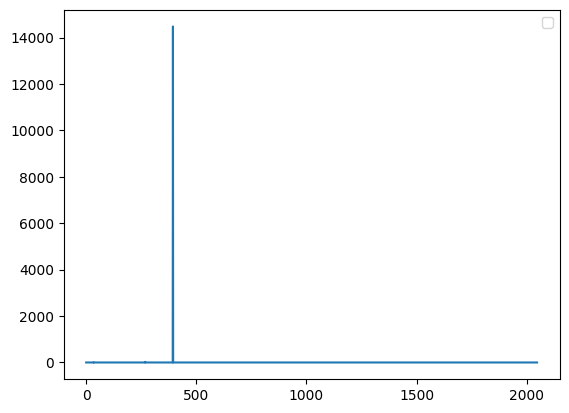

2023-09-27 15:03:09 WARNING posx and posy should be finite values
2023-09-27 15:03:09 WARNING posx and posy should be finite values


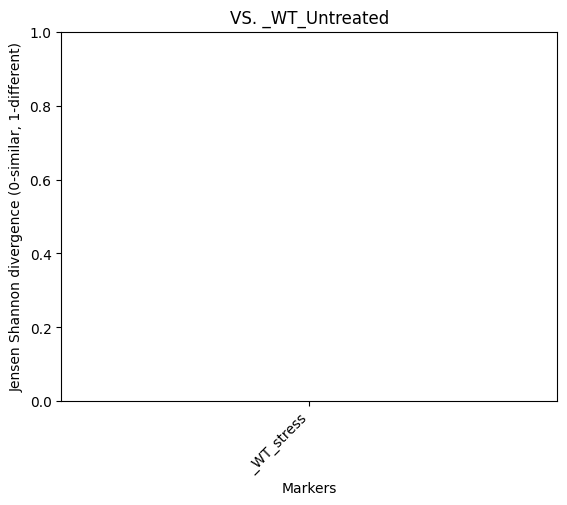

In [90]:
h0_label = "_WT_Untreated"

h0_x = sm_hist(h0_label) #select_samples_by_label(ind, labels, [h0_label], is_contains=True)
# h0 = h0_x.sum(0)/len(h0_y)
print(h0_x)
l = ["_WT_stress"] #["FUS_TDP43_Untreated", "FUS_WT_Untreated", "FUS_FUSHeterozygous_Untreated", "FUS_FUSRevertant_Untreated"]
X, Y = [], []

for ll in l:
    print(ll)
    x= sm_hist(l) #select_samples_by_label(ind, labels, [ll], is_contains=True)#, end_ind=20)
    print(x.shape)#, len(y), np.unique(y))
    # img = x.sum(0)/len(y)
    # print(max(img), np.argmax(img))
    X.append(x)
    print(x)
    # Y.append(y)

plt.plot(np.arange(0,2048), h0_x)
# for x in X:
#     plt.plot(np.arange(0,2048), x)#_distribution)
plt.legend([h0_label] + l)
plt.show()

distances = []

for i in range(len(X)):
    # for j in range(i+1, len(X)):
        im_i, im_j = X[i], h0_x #X[i], X[j]
        distances.append(round(jensen_shannon_divergence(im_i, im_j), 4))


plt.bar(l, distances)

# Annotate the bars with their y-values
for i, v in enumerate(distances):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
    
plt.ylim(0,1)
plt.xlabel("Markers")
plt.ylabel("Jensen Shannon divergence (0-similar, 1-different)")
plt.xticks(rotation=45, ha='right')
plt.title(f"VS. {h0_label}")
plt.show()


In [28]:
images = [image_untreated, image_stress]
images_names = ["Untreated", "stress"]

distances = []

for i in range(len(images)):
    for j in range(i+1, len(images)):
        im_i, im_j = images[i], images[j]
        distances.append([images_names[i], images_names[j], round(jensen_shannon_divergence(im_i, im_j), 5)])

distances

[['Untreated', 'stress', 0.10131]]

In [ ]:
select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"], end_ind=20)

(20, 1) ['G3BP1_WT_Untreated']
(696, 1) ['G3BP1_WT_Untreated']
912.0 1529
764.0 1529


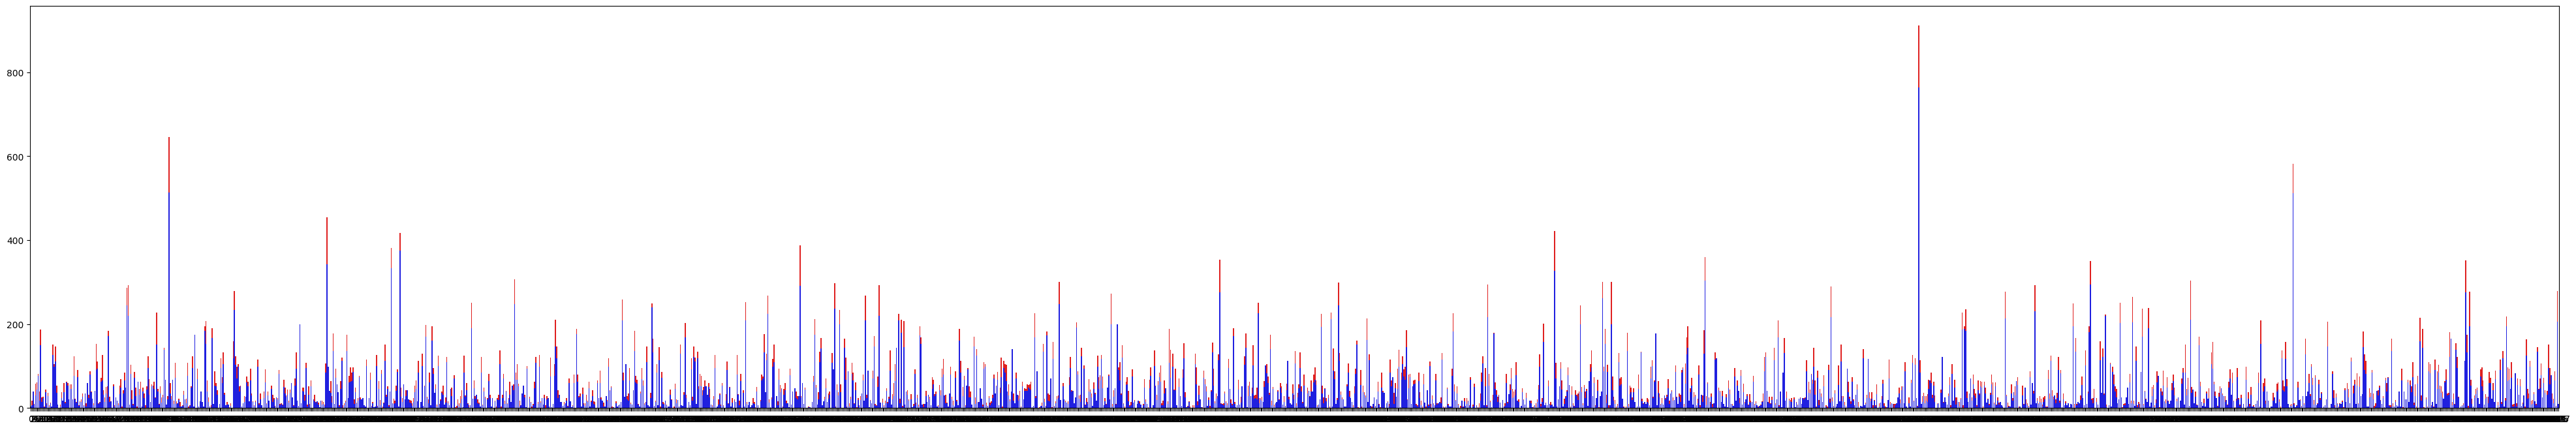

In [22]:
# # "G3BP1_WT_Untreated"
# ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"], end_ind=20)#, n_samples=20)

# print(labels_g3bp1.shape, np.unique(labels_g3bp1))

# ind_g3bp1_hist_untreated1 = ind_g3bp1.sum(0)



# ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"], start_ind=20)#, n_samples=20)

# print(labels_g3bp1.shape, np.unique(labels_g3bp1))

# ind_g3bp1_hist_untreated = ind_g3bp1.sum(0)

# print(max(ind_g3bp1_hist_untreated), np.argmax(ind_g3bp1_hist_untreated))

# fig = plt.figure(figsize=(50,8))
# sns.barplot(x=np.arange(0,2048), y=ind_g3bp1_hist_untreated, color='red')
# # plt.xticks(np.arange(0,2047))
# ind_g3bp1_stress, labels_g3bp1_stress = select_samples_by_label(ind, labels, ["G3BP1_WT_stress"])#, n_samples=20)
# ind_g3bp1_hist_stress = ind_g3bp1_stress.sum(0)
# print(max(ind_g3bp1_hist_stress), np.argmax(ind_g3bp1_hist_stress))

# sns.barplot(x=np.arange(0,2048), y=ind_g3bp1_hist_stress, color='blue')
# plt.show()

# # corr_idx_idx = calc_corr_vqindhist(vq_idx=2, use_codebook=False, model=None,
# #                                    ind=ind_g3bp1, labels=labels_g3bp1.reshape(-1,), unique_labels=np.unique(labels_g3bp1.reshape(-1,)))
# # # corr_idx_idx = calc_corr_vqindhist(vq_idx=2, use_codebook=True, model=model)

# # print(corr_idx_idx.shape)
# # sns.heatmap(corr_idx_idx)#, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

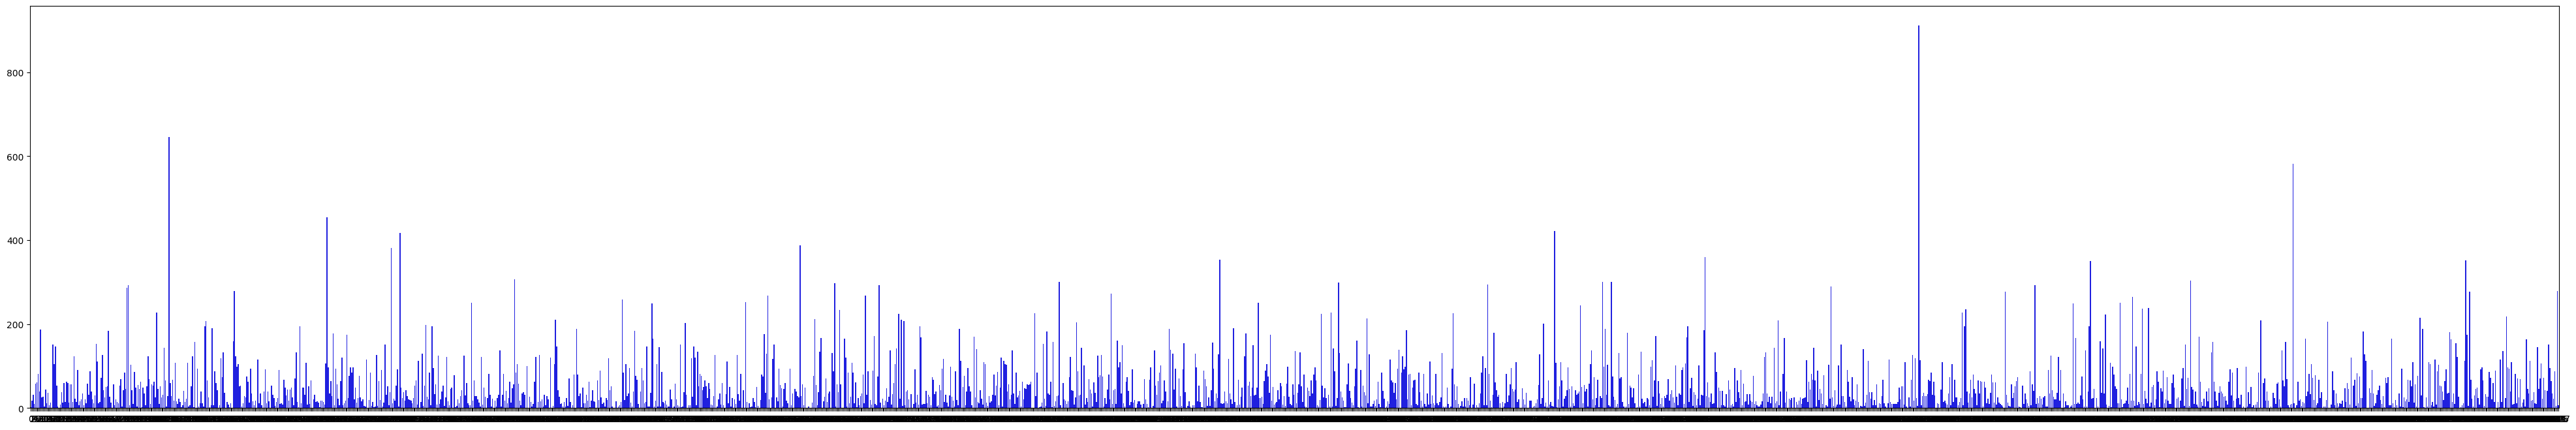

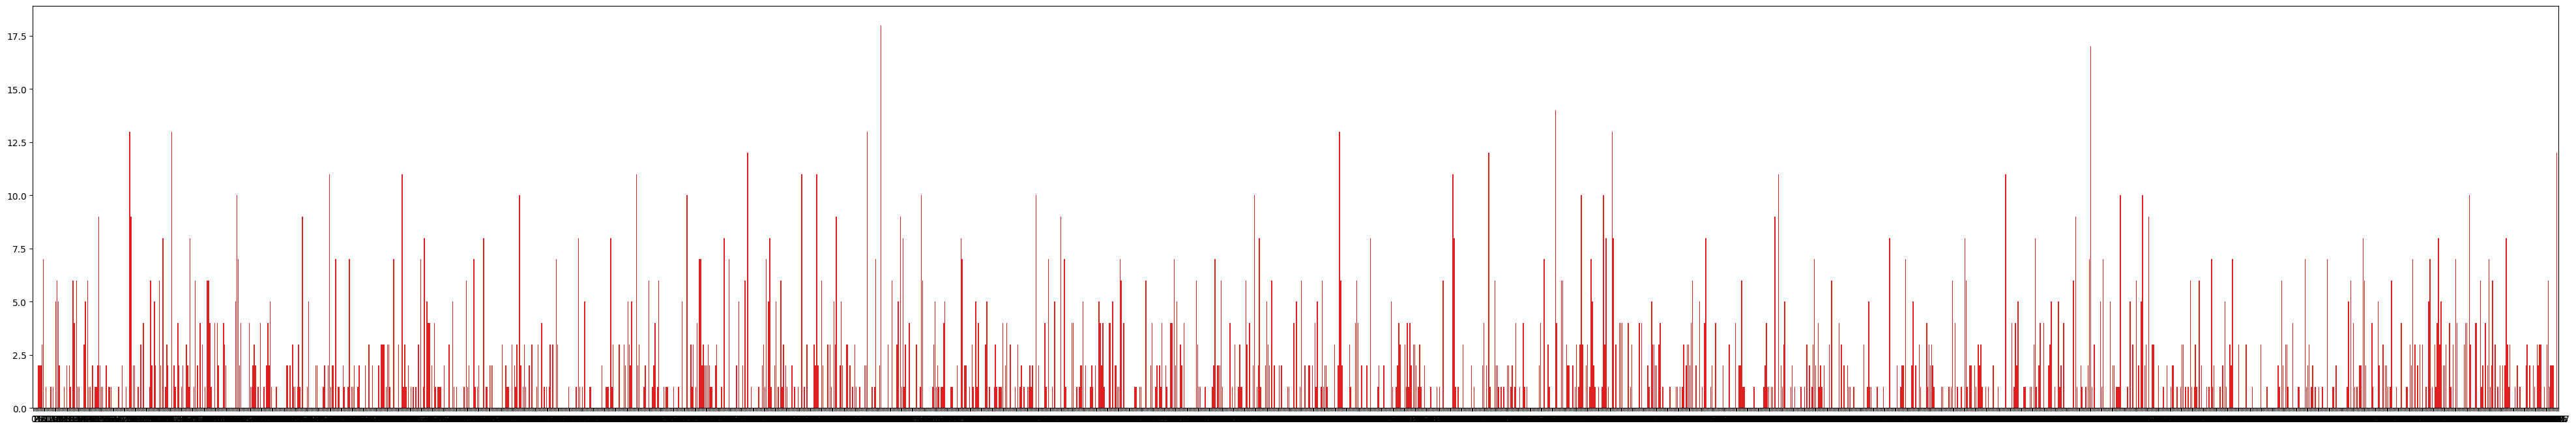

In [23]:
# fig = plt.figure(figsize=(50,8))
# sns.barplot(x=np.arange(0,2048), y=ind_g3bp1_hist_untreated, color='blue')
# plt.show()

# fig = plt.figure(figsize=(50,8))
# sns.barplot(x=np.arange(0,2048), y=ind_g3bp1_hist_untreated1, color='red')
# plt.show()

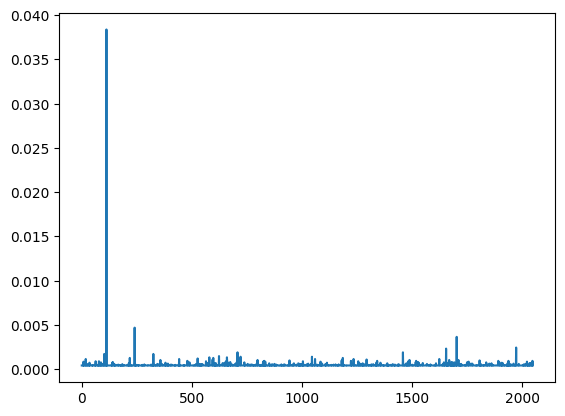

In [125]:
# ind_g3bp1_hist_untreated1/20, softmax(ind_g3bp1_hist_untreated1/20)
# plt.plot(softmax(ind_g3bp1_hist_untreated1/20))
# #, np.argmax(ind_g3bp1_hist_untreated1)

In [19]:
# image1 = ind_g3bp1_hist_untreated1/20
# image2 = ind_g3bp1_hist_untreated/696
# image3 = ind_g3bp1_hist_stress / len(ind_g3bp1_stress)

# image1_distribution = softmax(image1)
# image2_distribution = softmax(image2)
# image3_distribution = softmax(image3)

# print(np.sum(softmax(ind_g3bp1_hist_untreated/696)), np.sum(softmax(ind_g3bp1_hist_untreated1/20)), np.sum(image3_distribution))

# # plt.plot(np.arange(0,2048), image1)#_distribution)
# plt.plot(np.arange(0,2048), image2)#_distribution)
# # plt.plot(np.arange(0,2048), image3)#_distribution)
# plt.plot(np.arange(0,2048), image4)#_distribution)
# plt.plot(np.arange(0,2048), image5)#_distribution)
# plt.show()

# plt.plot(np.arange(0,2048), image1_distribution)
# plt.plot(np.arange(0,2048), image2_distribution)
# plt.plot(np.arange(0,2048), image3_distribution)

In [44]:
x, y = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"], end_ind=20)
print(x.shape, len(y), np.unique(y))
image1 = x.sum(0)/len(y)
print(max(image1), np.argmax(image1))

x, y = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"], start_ind=20)
print(x.shape, len(y), np.unique(y))
image2 = x.sum(0)/len(y)
print(max(image2), np.argmax(image2))

x, y = select_samples_by_label(ind, labels, ["G3BP1_WT_stress"])
print(x.shape, len(y), np.unique(y))
image3 = x.sum(0)/len(y)
print(max(image3), np.argmax(image3))

x, y = select_samples_by_label(ind, labels, ["FMRP_WT_Untreated"])#, n_samples=20)
print(x.shape, len(y), np.unique(y))
image4 = x.sum(0)/len(y)
print(max(image4), np.argmax(image4))

x, y = select_samples_by_label(ind, labels, ["FMRP_WT_stress"])#, n_samples=20)
print(x.shape, len(y), np.unique(y))
image5 = x.sum(0)/len(y)
print(max(image5), np.argmax(image5))


# image4_distribution = softmax(image4)
# image5_distribution = softmax(image5)


x, y = select_samples_by_label(ind, labels, ["FUS_WT_Untreated"])#, n_samples=20)
print(x.shape, len(y), np.unique(y))
image6 = x.sum(0)/len(y)
print(max(image6), np.argmax(image6))

x, y = select_samples_by_label(ind, labels, ["FMRP_FUSHeterozygous_Untreated"])#, n_samples=20)
print(x.shape, len(y), np.unique(y))
image7 = x.sum(0)/len(y)
print(max(image7), np.argmax(image7))

x, y = select_samples_by_label(ind, labels, ["FUS_FUSRevertant_Untreated"])#, n_samples=20)
print(x.shape, len(y), np.unique(y))
image8 = x.sum(0)/len(y)
print(max(image8), np.argmax(image8))

(20, 2048) 20 ['G3BP1_WT_Untreated']
14.7 330
(696, 2048) 696 ['G3BP1_WT_Untreated']
17.590517 330
(560, 2048) 560 ['G3BP1_WT_stress']
14.591071 330
(755, 2048) 755 ['FMRP_WT_Untreated']
13.754967 152
(663, 2048) 663 ['FMRP_WT_stress']
15.809955 152
(655, 2048) 655 ['FUS_WT_Untreated']
90.75878 37
(558, 2048) 558 ['FMRP_FUSHeterozygous_Untreated']
13.709678 152
(638, 2048) 638 ['FUS_FUSRevertant_Untreated']
61.11912 1318


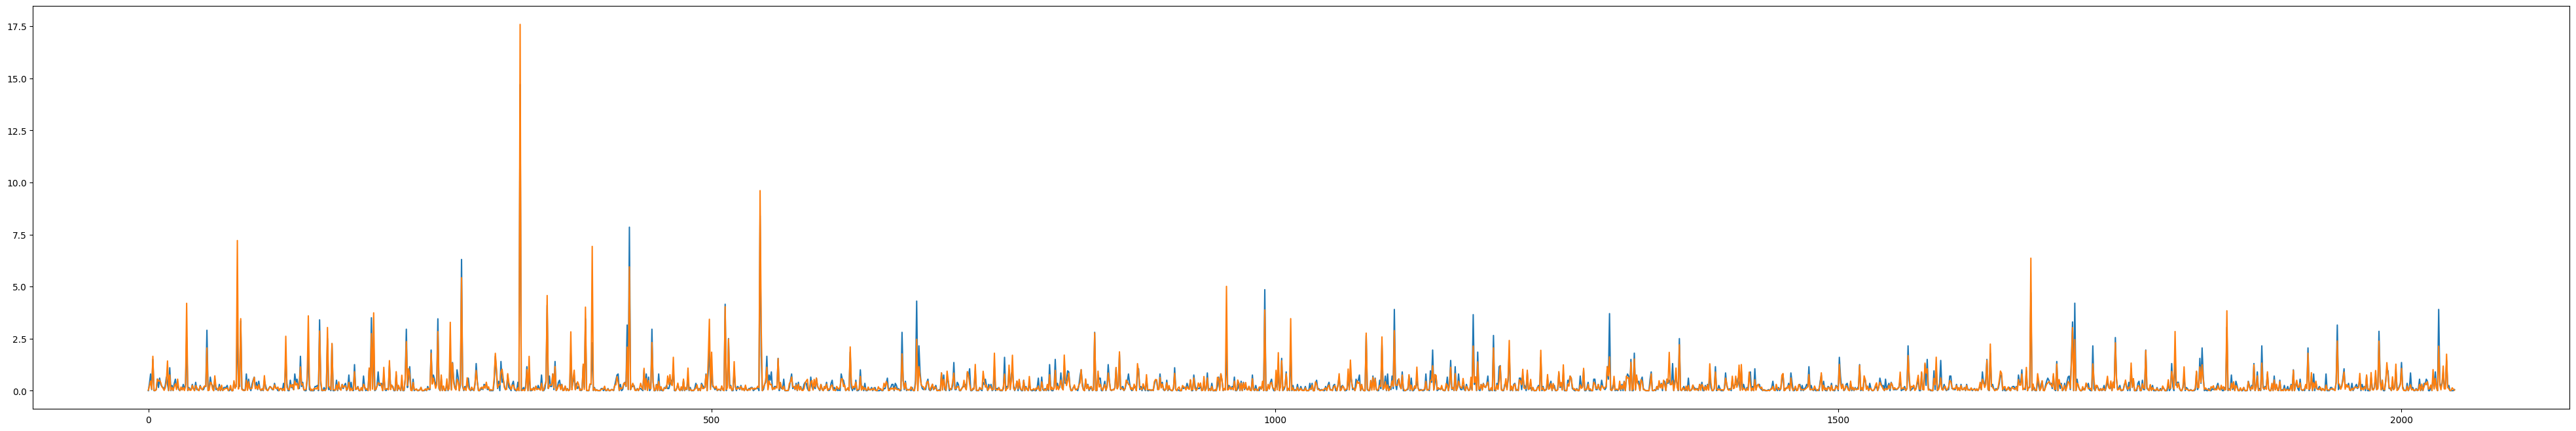

In [46]:
fig = plt.figure(figsize=(50,8))

plt.plot(np.arange(0,2048), image1)#_distribution)
plt.plot(np.arange(0,2048), image2)#_distribution)
# plt.plot(np.arange(0,2048), image3)#_distribution)
# plt.plot(np.arange(0,2048), image4)#_distribution)
# plt.plot(np.arange(0,2048), image5)#_distribution)
# plt.plot(np.arange(0,2048), image6)#_distribution)
# plt.plot(np.arange(0,2048), image7)#_distribution)
# plt.plot(np.arange(0,2048), image8)#_distribution)

# plt.xticks(np.arange(0,2048))

plt.show()

In [48]:
np.unique(labels)

array(['FMRP_FUSHeterozygous_Untreated', 'FMRP_FUSRevertant_Untreated',
       'FMRP_TDP43_Untreated', 'FMRP_WT_Untreated', 'FMRP_WT_stress',
       'FUS_FUSHeterozygous_Untreated', 'FUS_FUSRevertant_Untreated',
       'FUS_TDP43_Untreated', 'FUS_WT_Untreated', 'FUS_WT_stress',
       'G3BP1_FUSHeterozygous_Untreated', 'G3BP1_FUSRevertant_Untreated',
       'G3BP1_TDP43_Untreated', 'G3BP1_WT_Untreated', 'G3BP1_WT_stress',
       'NONO_FUSHeterozygous_Untreated', 'NONO_FUSRevertant_Untreated',
       'NONO_TDP43_Untreated', 'NONO_WT_Untreated', 'NONO_WT_stress',
       'PURA_FUSHeterozygous_Untreated', 'PURA_FUSRevertant_Untreated',
       'PURA_TDP43_Untreated', 'PURA_WT_Untreated', 'PURA_WT_stress'],
      dtype='<U38')

In [18]:
# KL Divergence

from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.special import softmax
from sklearn.metrics import mutual_info_score

# Compute the probability distributions of codeword usage for each image
# image1_distribution = softmax(ind_g3bp1_hist_untreated1/20)
# image2_distribution = softmax(ind_g3bp1_hist_untreated/696)

# symmetrized version of KL divergence
def jensen_shannon_divergence(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

# Compute the KL divergence
# dist = jensen_shannon_divergence(image6, image7)
# dist, pval = ks_2samp(image2, image3)
# kl_divergence = entropy(image2_distribution, image3_distribution)


# # You can also calculate the reverse KL divergence if needed
# reverse_kl_divergence = entropy(image2_distribution, image1_distribution)

# Set a threshold to determine if the distributions are significantly different
# threshold = 0.05  # You can adjust this based on your significance level
# print(dist)
# print(pval)
# if pval > threshold:
#     print("The codeword usage distributions are significantly different.")
# else:
#     print("The codeword usage distributions are similar.")


vq2

In [34]:
images = [image1, image2, image3, image4, image5, image6, image7, image8]
images_names = ["G3BP1", "G3BP1_2", "G3BP1_stress",
                "FMRP", "FMRP_stress", "FUS_WT",  "FUS_FUSHeterozygous", "FUS_FUSRevertant"]

distances = []

for i in range(len(images)):
    for j in range(i+1, len(images)):
        im_i, im_j = images[i], images[j]
        distances.append([images_names[i], images_names[j], round(jensen_shannon_divergence(im_i, im_j), 2)])

distances

[['G3BP1', 'G3BP1_2', 0.12],
 ['G3BP1', 'G3BP1_stress', 0.12],
 ['G3BP1', 'FMRP', 0.11],
 ['G3BP1', 'FMRP_stress', 0.12],
 ['G3BP1', 'FUS_WT', 0.11],
 ['G3BP1', 'FUS_FUSHeterozygous', 0.12],
 ['G3BP1', 'FUS_FUSRevertant', 0.13],
 ['G3BP1_2', 'G3BP1_stress', 0.01],
 ['G3BP1_2', 'FMRP', 0.01],
 ['G3BP1_2', 'FMRP_stress', 0.01],
 ['G3BP1_2', 'FUS_WT', 0.01],
 ['G3BP1_2', 'FUS_FUSHeterozygous', 0.01],
 ['G3BP1_2', 'FUS_FUSRevertant', 0.01],
 ['G3BP1_stress', 'FMRP', 0.01],
 ['G3BP1_stress', 'FMRP_stress', 0.01],
 ['G3BP1_stress', 'FUS_WT', 0.01],
 ['G3BP1_stress', 'FUS_FUSHeterozygous', 0.01],
 ['G3BP1_stress', 'FUS_FUSRevertant', 0.01],
 ['FMRP', 'FMRP_stress', 0.01],
 ['FMRP', 'FUS_WT', 0.01],
 ['FMRP', 'FUS_FUSHeterozygous', 0.01],
 ['FMRP', 'FUS_FUSRevertant', 0.01],
 ['FMRP_stress', 'FUS_WT', 0.01],
 ['FMRP_stress', 'FUS_FUSHeterozygous', 0.01],
 ['FMRP_stress', 'FUS_FUSRevertant', 0.01],
 ['FUS_WT', 'FUS_FUSHeterozygous', 0.01],
 ['FUS_WT', 'FUS_FUSRevertant', 0.01],
 ['FUS_FUSHetero

vq1

In [49]:
images = [image1, image2, image3, image4, image5, image6, image7, image8]
images_names = ["G3BP1", "G3BP1_2", "G3BP1_stress",
                "FMRP", "FMRP_stress", "FUS_WT",  "FUS_FUSHeterozygous", "FUS_FUSRevertant"]

distances = []

for i in range(len(images)):
    for j in range(i+1, len(images)):
        im_i, im_j = images[i], images[j]
        distances.append([images_names[i], images_names[j], round(jensen_shannon_divergence(im_i, im_j), 2)])

distances

[['G3BP1', 'G3BP1_2', 0.04],
 ['G3BP1', 'G3BP1_stress', 0.11],
 ['G3BP1', 'FMRP', 0.14],
 ['G3BP1', 'FMRP_stress', 0.27],
 ['G3BP1', 'FUS_WT', 0.5],
 ['G3BP1', 'FUS_FUSHeterozygous', 0.13],
 ['G3BP1', 'FUS_FUSRevertant', 0.46],
 ['G3BP1_2', 'G3BP1_stress', 0.07],
 ['G3BP1_2', 'FMRP', 0.1],
 ['G3BP1_2', 'FMRP_stress', 0.23],
 ['G3BP1_2', 'FUS_WT', 0.48],
 ['G3BP1_2', 'FUS_FUSHeterozygous', 0.1],
 ['G3BP1_2', 'FUS_FUSRevertant', 0.45],
 ['G3BP1_stress', 'FMRP', 0.09],
 ['G3BP1_stress', 'FMRP_stress', 0.16],
 ['G3BP1_stress', 'FUS_WT', 0.47],
 ['G3BP1_stress', 'FUS_FUSHeterozygous', 0.08],
 ['G3BP1_stress', 'FUS_FUSRevertant', 0.45],
 ['FMRP', 'FMRP_stress', 0.16],
 ['FMRP', 'FUS_WT', 0.49],
 ['FMRP', 'FUS_FUSHeterozygous', 0.01],
 ['FMRP', 'FUS_FUSRevertant', 0.46],
 ['FMRP_stress', 'FUS_WT', 0.47],
 ['FMRP_stress', 'FUS_FUSHeterozygous', 0.16],
 ['FMRP_stress', 'FUS_FUSRevertant', 0.4],
 ['FUS_WT', 'FUS_FUSHeterozygous', 0.49],
 ['FUS_WT', 'FUS_FUSRevertant', 0.12],
 ['FUS_FUSHeterozygo

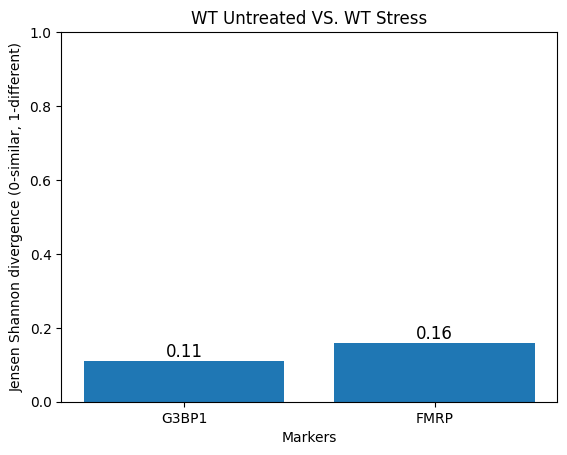

In [67]:
values = [round(jensen_shannon_divergence(image1, image3), 2), round(jensen_shannon_divergence(image4, image5), 2)]

plt.bar(['G3BP1','FMRP'], values)

# Annotate the bars with their y-values
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
    
plt.ylim(0,1)
plt.xlabel("Markers")
plt.ylabel("Jensen Shannon divergence (0-similar, 1-different)")
plt.title("WT Untreated VS. WT Stress")
plt.show()

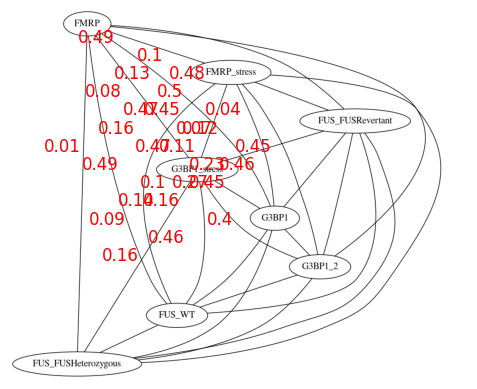

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
import numpy as np
from PIL import Image


# Create an empty graph
G = nx.Graph()

# Add nodes (objects) to the graph
objects = set()
for distance in distances:
    objects.add(distance[0])
    objects.add(distance[1])

G.add_nodes_from(objects)

# Add edges (with lengths) to the graph
for distance in distances:
    G.add_edge(distance[0], distance[1], weight=distance[2])

# Create a pygraphviz graph from the networkx graph
pgv_graph = nx.nx_agraph.to_agraph(G)

# Get edge weights (distances) for adjusting layout
edge_weights = {edge: weight for edge, weight in nx.get_edge_attributes(G, "weight").items()}

# Get edge weights (distances) for varying edge colors
__edge_weights = [d["weight"] for u, v, d in G.edges(data=True)]
min_weight, max_weight = min(__edge_weights), max(__edge_weights)

# Create a color map to map weights to colors
cmap = plt.get_cmap("hot_r")  # You can choose a different colormap
edge_colors = [cmap((weight - min_weight) / (max_weight - min_weight)) for weight in __edge_weights]
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

# Set edge lengths based on weights
for edge in pgv_graph.edges():
    u, v = edge
    weight = G[u][v]['weight']
    edge.attr['len'] = str(1 + weight / 10.0)  # Adjust the divisor to control the scaling


# Draw the graph using Graphviz
pgv_graph.layout(prog='dot')

# plt.figure(figsize=(20, 15))
# nx.draw(G, pgv_graph, with_labels=True, node_size=1000, node_color="skyblue", font_size=14, font_color="black", edge_color=edge_colors, width=2)
# nx.draw_networkx_edge_labels(G, pgv_graph, edge_labels=edge_labels, font_size=14)
# plt.title("Graph with Adjusted Edge Lengths Based on Weights")
# plt.show()

output_file = "weighted_graph.png"
pgv_graph.draw(output_file)

# # # Display the image (optional)
# # img = Image.open(output_file)
# # img.show()

# # Display the image using plt.imshow
img = plt.imread(output_file)
plt.imshow(img)


for edge in G.edges(data=True):
    u, v, data = edge
    weight = data['weight']
    pos_u = [float(coord) for coord in pgv_graph.get_node(u).attr['pos'].split(',')]
    pos_v = [float(coord) for coord in pgv_graph.get_node(v).attr['pos'].split(',')]
    x = (pos_u[0] + pos_v[0]) / 2.0
    y = (pos_u[1] + pos_v[1]) / 2.0
    plt.text(x, y, str(weight), color='red', fontsize=12, ha='center', va='center')


plt.axis('off')  # Turn off axis labels and ticks
plt.show()

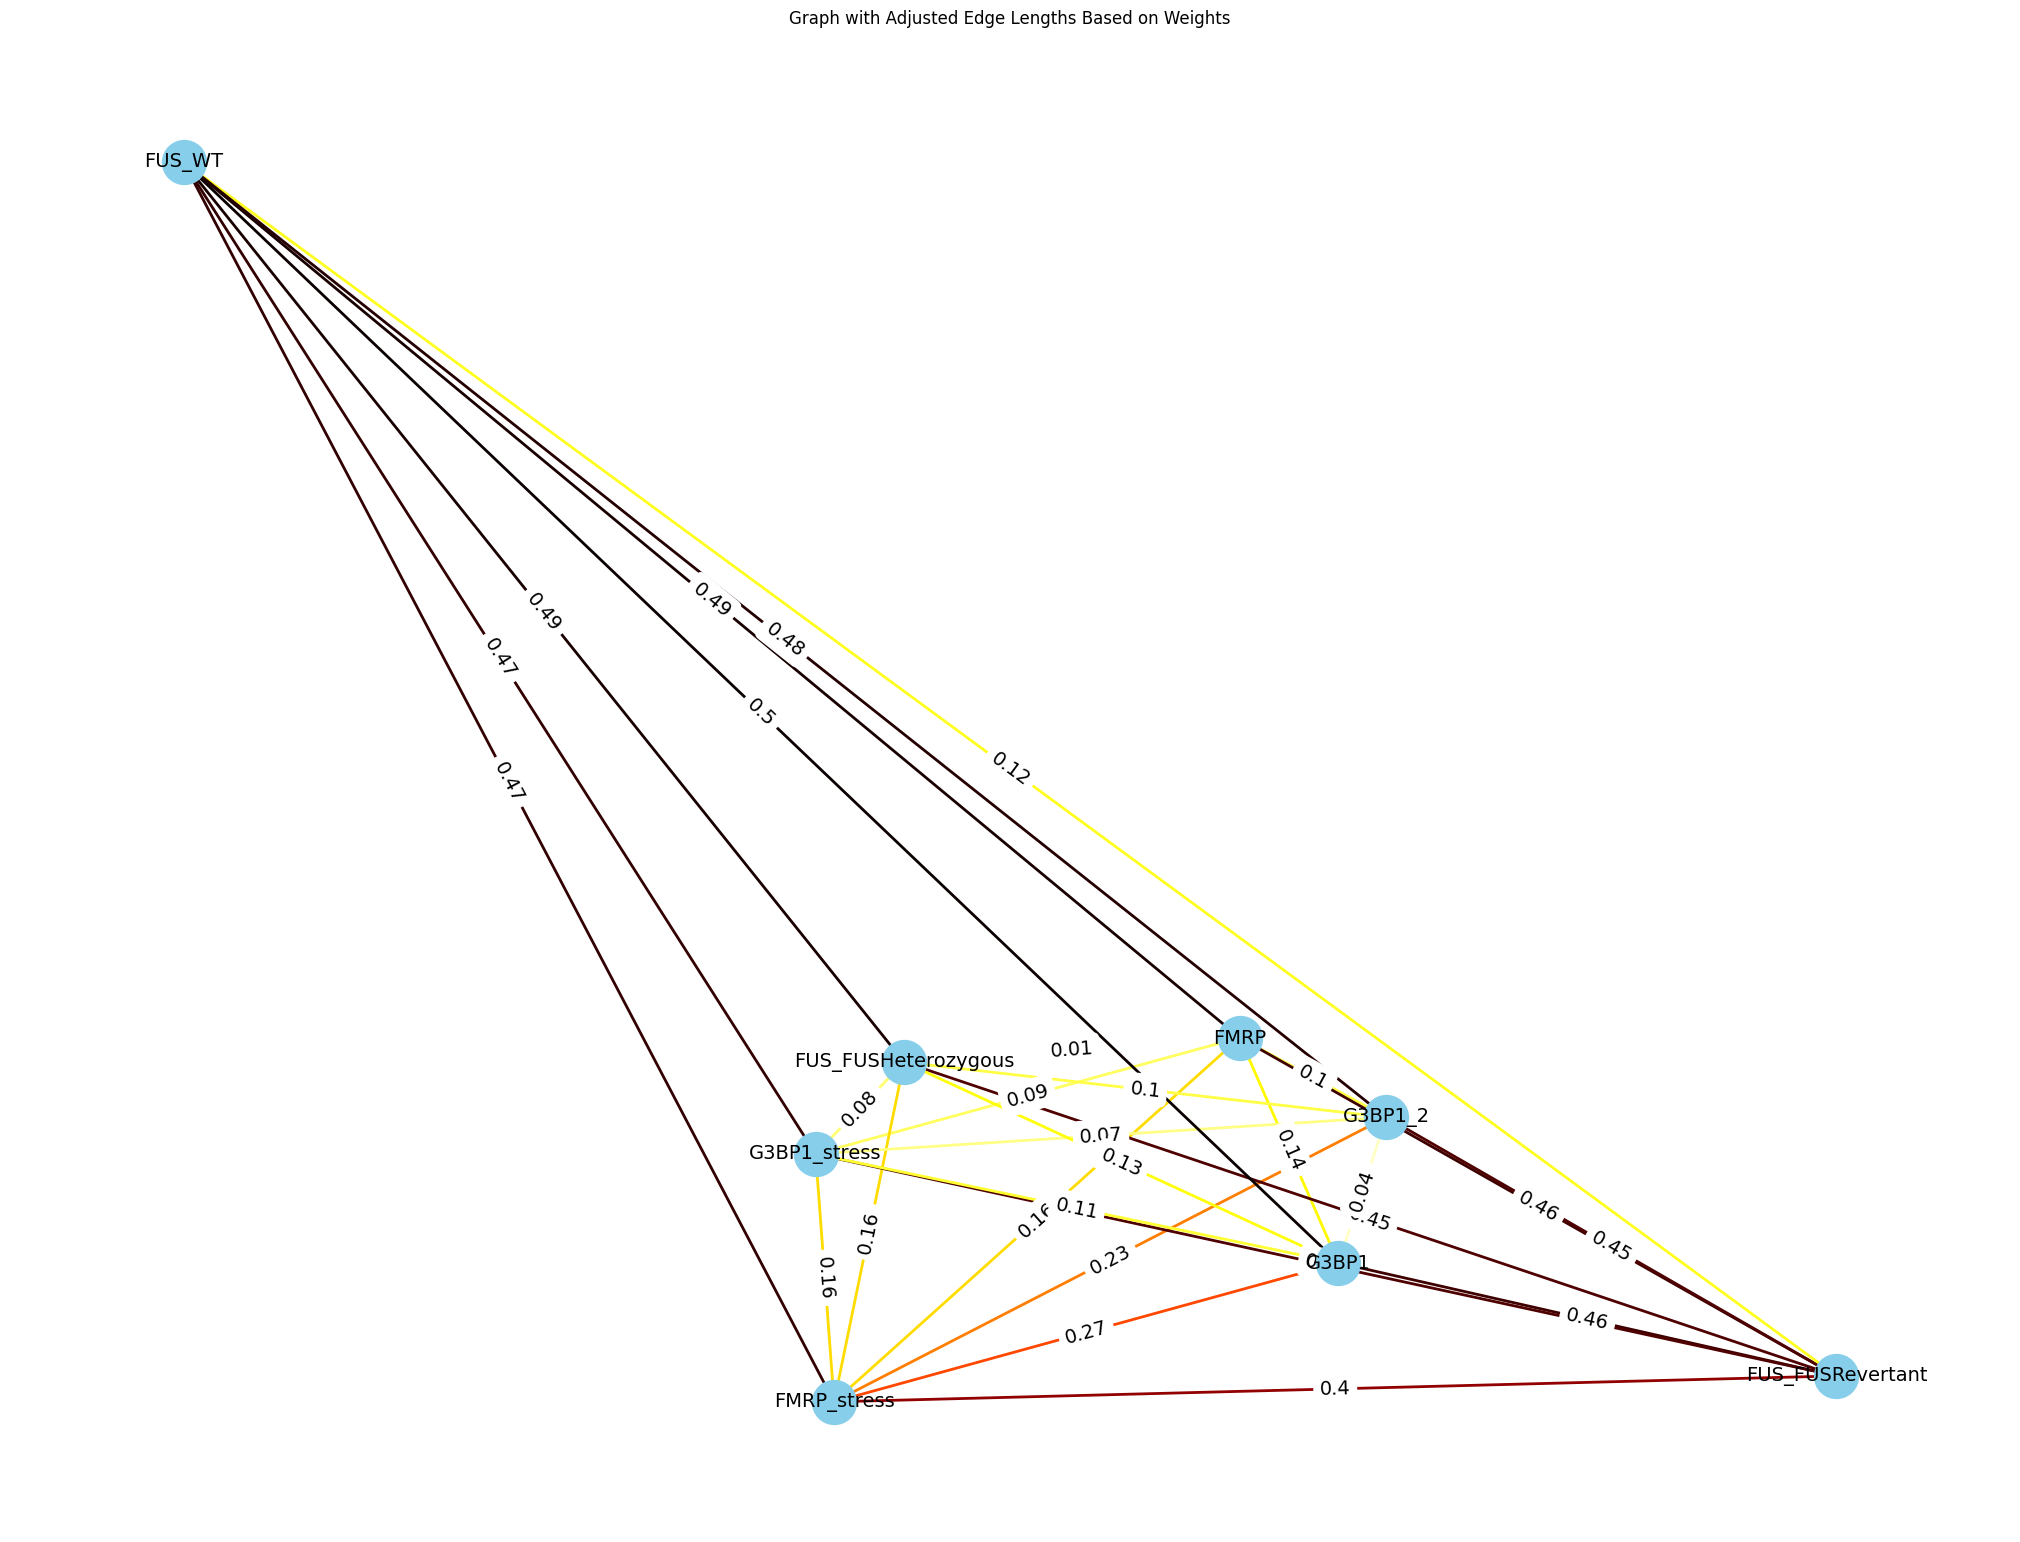

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Create an empty graph
G = nx.Graph()

# Add nodes (objects) to the graph
objects = set()
for distance in distances:
    objects.add(distance[0])
    objects.add(distance[1])

G.add_nodes_from(objects)

# Add edges (with lengths) to the graph
for distance in distances:
    G.add_edge(distance[0], distance[1], weight=distance[2])

# Define the layout for the nodes (you can choose other layouts as well)
pos = nx.spring_layout(G)


# Get edge weights (distances) for adjusting layout
edge_weights = {edge: weight for edge, weight in nx.get_edge_attributes(G, "weight").items()}

# Get edge weights (distances) for varying edge colors
__edge_weights = [d["weight"] for u, v, d in G.edges(data=True)]
min_weight, max_weight = min(__edge_weights), max(__edge_weights)

# Create a color map to map weights to colors
cmap = plt.get_cmap("hot_r")  # You can choose a different colormap
edge_colors = [cmap((weight - min_weight) / (max_weight - min_weight)) for weight in __edge_weights]
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

# Adjust layout based on edge weights
for edge, weight in edge_weights.items():
    u, v = edge
    # Increase the length of edges with larger weights
    layout_distance = 1.0 + weight * 5.0 # / 10.0  # Adjust the divisor to control the scaling
    pos[u][0] *= layout_distance
    pos[u][1] *= layout_distance
    pos[v][0] *= layout_distance
    pos[v][1] *= layout_distance

# Create the graph visualization with adjusted layout
plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=14, font_color="black", edge_color=edge_colors, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
plt.title("Graph with Adjusted Edge Lengths Based on Weights")
plt.show()





# # Get edge weights (distances) for varying edge colors
# edge_weights = [d["weight"] for u, v, d in G.edges(data=True)]
# min_weight, max_weight = min(edge_weights), max(edge_weights)

# # Create a color map to map weights to colors
# cmap = plt.get_cmap("hot_r")  # You can choose a different colormap
# edge_colors = [cmap((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights]
# edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

# # Create the graph visualization with varying edge colors
# plt.figure(figsize=(10, 6))
# nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black",
#         edge_color=edge_colors, width=2)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
# plt.title("Graph with Varying Edge Colors (Based on Weights)")
# plt.show()


-----------------------------------

## VQ IND

Computing self Pearson correlation...
(2048, 64)





























































































100%|██████████| 64/64 [00:01<00:00, 37.06it/s]


(64, 64)


<AxesSubplot:>

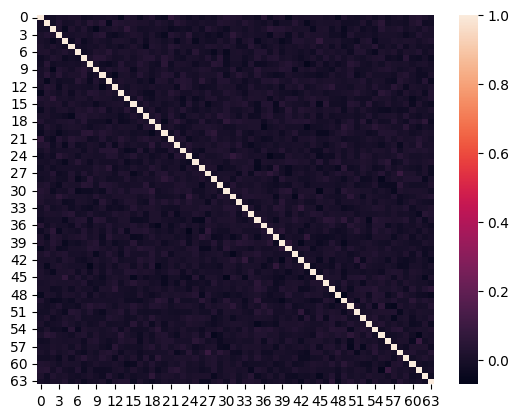

In [129]:
# "G3BP1_WT_Untreated"
ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"])

# corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=False, model=None, ind=ind_g3bp1, labels=labels_g3bp1.reshape(-1,), unique_labels=np.unique(labels_g3bp1.reshape(-1,)))
corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=True, model=model)

print(corr_idx_idx.shape)
sns.heatmap(corr_idx_idx)#, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

[[ 0.00494685 -0.0186809   0.03323514 ...  0.00510563  0.01361956
  -0.02734126]
 [-0.0209861  -0.012891    0.00840307 ... -0.02620369  0.03440234
   0.00381777]
 [ 0.01563451  0.0341985  -0.02684814 ...  0.00188786  0.02070145
   0.02619385]
 ...
 [ 0.02712378 -0.01567555 -0.00544082 ... -0.03160759 -0.00531413
  -0.01442262]
 [-0.00484627 -0.00255377 -0.03534115 ... -0.02528096  0.00672683
   0.0252571 ]
 [ 0.03405032 -0.00588157  0.02229762 ... -0.03826705  0.03245366
   0.0147725 ]]
Computing self Spearman correlation...
(2048, 64)


















































































































100%|██████████| 64/64 [00:02<00:00, 28.87it/s]


(64, 64)


<AxesSubplot:>

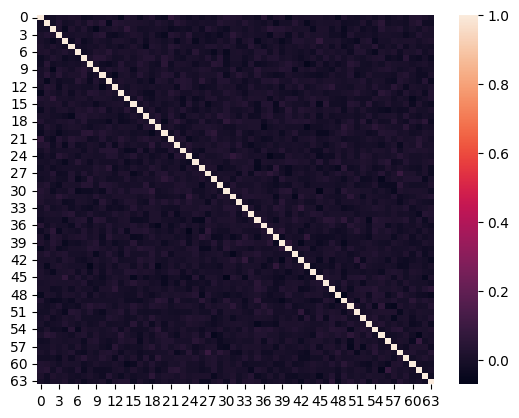

In [135]:
# "G3BP1_WT_Untreated"
ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"])

# corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=False, model=None, ind=ind_g3bp1, labels=labels_g3bp1.reshape(-1,), unique_labels=np.unique(labels_g3bp1.reshape(-1,)))
corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=True, model=model)

print(corr_idx_idx.shape)
sns.heatmap(corr_idx_idx)#, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

[[-0.02407863  0.02544666 -0.0335152  ...  0.01040253 -0.02956903
  -0.01555218]
 [-0.02765546  0.00828968 -0.01913405 ... -0.01253887 -0.01412991
  -0.01347501]
 [-0.00654059  0.0044022   0.00115947 ... -0.02063258 -0.00631044
   0.03436699]
 ...
 [-0.01270567 -0.01703161  0.01832943 ... -0.02037388  0.00580788
   0.01304139]
 [-0.03475548 -0.01677921 -0.02225887 ...  0.03400385 -0.02986334
  -0.00261401]
 [ 0.02869446 -0.03592048  0.0339369  ... -0.01061917  0.0300839
   0.02508722]]
Computing self Pearson correlation...
(2048, 64)





























































































100%|██████████| 64/64 [00:01<00:00, 35.52it/s]


(64, 64)


<AxesSubplot:>

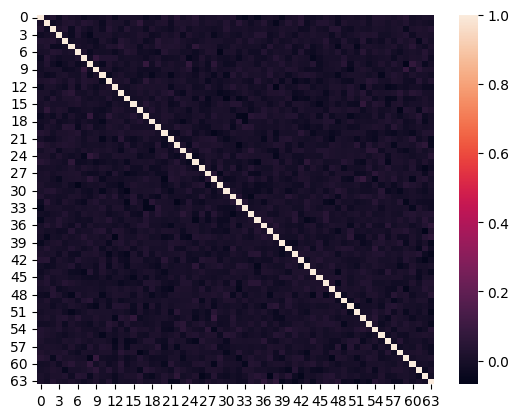

In [140]:
# "G3BP1_WT_Untreated"
ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"])

# corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=False, model=None, ind=ind_g3bp1, labels=labels_g3bp1.reshape(-1,), unique_labels=np.unique(labels_g3bp1.reshape(-1,)))
corr_idx_idx = calc_corr_vqind(vq_idx=2, use_codebook=True, model=model)

print(corr_idx_idx.shape)
sns.heatmap(corr_idx_idx)#, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

[[-0.02407863  0.02544666 -0.0335152  ...  0.01040253 -0.02956903
  -0.01555218]
 [-0.02765546  0.00828968 -0.01913405 ... -0.01253887 -0.01412991
  -0.01347501]
 [-0.00654059  0.0044022   0.00115947 ... -0.02063258 -0.00631044
   0.03436699]
 ...
 [-0.01270567 -0.01703161  0.01832943 ... -0.02037388  0.00580788
   0.01304139]
 [-0.03475548 -0.01677921 -0.02225887 ...  0.03400385 -0.02986334
  -0.00261401]
 [ 0.02869446 -0.03592048  0.0339369  ... -0.01061917  0.0300839
   0.02508722]]
Computing self Spearman correlation...
(2048, 64)





























































































100%|██████████| 64/64 [00:02<00:00, 31.35it/s]


(64, 64)


<AxesSubplot:>

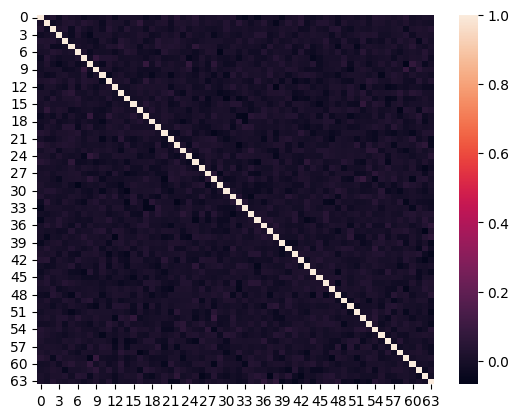

In [136]:
# "G3BP1_WT_Untreated"
ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"])

# corr_idx_idx = calc_corr_vqind(vq_idx=1, use_codebook=False, model=None, ind=ind_g3bp1, labels=labels_g3bp1.reshape(-1,), unique_labels=np.unique(labels_g3bp1.reshape(-1,)))
corr_idx_idx = calc_corr_vqind(vq_idx=2, use_codebook=True, model=model)

print(corr_idx_idx.shape)
sns.heatmap(corr_idx_idx)#, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

No correlation between codeword.. No collapse for vq1 and vq2

---

(716, 625) (716, 1)
['G3BP1_WT_Untreated']
0.9812358228519711


<AxesSubplot:>

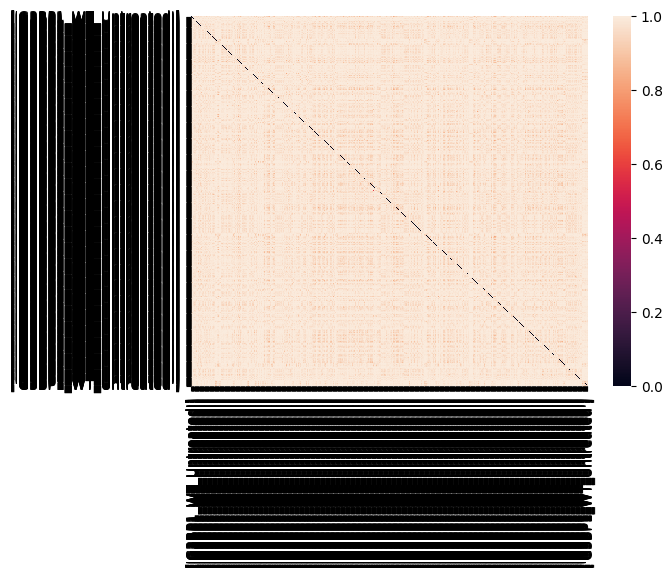

In [150]:

# "G3BP1_WT_Untreated"
ind_g3bp1, labels_g3bp1 = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated"])
print(ind_g3bp1.shape, labels_g3bp1.shape)
print(np.unique(labels_g3bp1))

g3bp1_distances = calculate_pairwise_distance(ind_g3bp1, calculate_hamming_distance)

print(np.mean(g3bp1_distances))

sns.heatmap(g3bp1_distances, xticklabels=labels_g3bp1, yticklabels=labels_g3bp1)

0.9817856644490527


<AxesSubplot:>

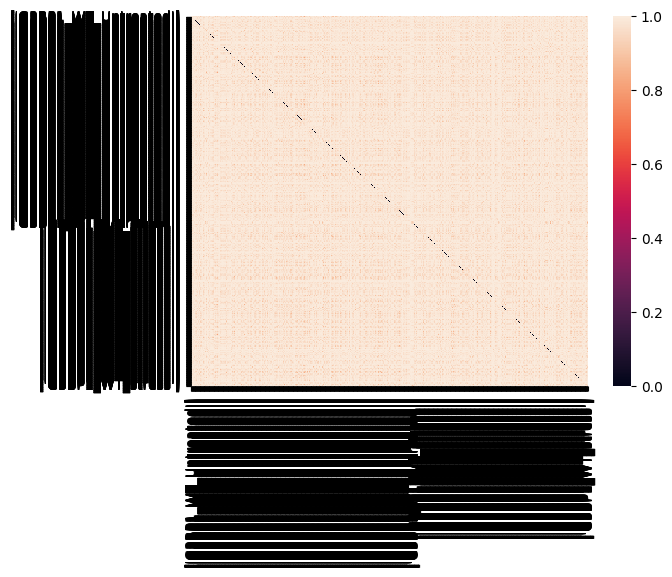

In [151]:

# "G3BP1_WT_Untreated", "G3BP1_WT_stress"
ind_g3bp1_cond, labels_g3bp1_cond = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated", "G3BP1_WT_stress"])
g3bp1_cond_distances = calculate_pairwise_distance(ind_g3bp1_cond, calculate_hamming_distance)

print(np.mean(g3bp1_cond_distances))

# sns.heatmap(g3bp1_cond_distances, xticklabels=labels_g3bp1_cond, yticklabels=labels_g3bp1_cond)

In [152]:

# "FMRP_WT_Untreated"
ind_fmrp, labels_fmrp = select_samples_by_label(ind, labels, ["FMRP_WT_Untreated"])
fmrp_distances = calculate_pairwise_distance(ind_fmrp, calculate_hamming_distance)

print(np.mean(fmrp_distances))

# sns.heatmap(fmrp_distances, xticklabels=labels_fmrp, yticklabels=labels_fmrp)

0.9806134397614141


In [155]:

# "FMRP_WT_Untreated", "FMRP_WT_stress"
ind_fmrp_cond, labels_fmrp_cond = select_samples_by_label(ind, labels, ["FMRP_WT_Untreated", "FMRP_WT_stress"])
print(ind_fmrp_cond.shape, labels_fmrp_cond.shape)

# from sklearn.model_selection import train_test_split

# labels_indexes = np.arange(len(labels_fmrp_cond))
# _, test_indexes = train_test_split(labels_indexes,
#                                                         test_size=0.1,
#                                                         random_state=config_data.SEED,
#                                                         shuffle=config_data.SHUFFLE,
#                                                         stratify=labels_fmrp_cond)
# ind_fmrp_cond, labels_fmrp_cond = ind_fmrp_cond[test_indexes], labels_fmrp_cond[test_indexes]

# print(ind_fmrp_cond.shape, labels_fmrp_cond.shape)
fmrp_cond_distances = calculate_pairwise_distance(ind_fmrp_cond, calculate_hamming_distance)

print(np.mean(fmrp_cond_distances))

# sns.heatmap(fmrp_cond_distances, xticklabels=labels_fmrp_cond, yticklabels=labels_fmrp_cond)

(1418, 625) (1418, 1)
0.9808330070163787


In [ ]:

# "NONO_WT_Untreated"
ind_nono, labels_nono = select_samples_by_label(ind, labels, ["NONO_WT_Untreated"])
nono_distances = calculate_pairwise_distance(ind_nono, calculate_hamming_distance)

print(np.mean(nono_distances))

sns.heatmap(nono_distances, xticklabels=labels_nono, yticklabels=labels_nono)

In [ ]:

# "NONO_WT_Untreated", "NONO_WT_stress"
ind_nono_cond, labels_nono_cond = select_samples_by_label(ind, labels, ["NONO_WT_Untreated", "NONO_WT_stress"])
nono_cond_distances = calculate_pairwise_distance(ind_nono_cond, calculate_hamming_distance)

print(np.mean(nono_cond_distances))

sns.heatmap(nono_cond_distances, xticklabels=labels_nono_cond, yticklabels=labels_nono_cond)

In [159]:

# "WT_Untreated_rep1_G3BP1", "WT_Untreated_rep1_NONO"
ind_g3bp1_nono, labels_g3bp1_nono = select_samples_by_label(ind, labels, ["G3BP1_WT_Untreated", "NONO_WT_Untreated"])
g3bp1_nono_distances = calculate_pairwise_distance(ind_g3bp1_nono, calculate_hamming_distance)

print(np.mean(g3bp1_nono_distances))

# sns.heatmap(g3bp1_cond_distances, xticklabels=labels_g3bp1_nono, yticklabels=labels_g3bp1_nono)

0.9811473394036211


Please caclculate between the two labels and not within them because it might distort the 'mean'!

# Misc

In [ ]:
# if use_codebook:
#     _mat_idx = self.trainer.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()
# else:
